# Testing performance of Numba implementation of GreedySearch without the objective function as a higher order function

## Imports

In [1]:
from realkd.rules import RuleBoostingEstimator, XGBRuleEstimator, logistic_loss
from realkd.search import search_methods
from numba import njit, parallel_chunksize
import pandas as pd
import sortednp as snp
import doctest
from realkd.search import GreedySearch
import matplotlib.pyplot as plt

from collections import defaultdict, deque
from sortedcontainers import SortedSet
from math import inf
from heapq import heappop, heappush
from numpy import array
from bitarray import bitarray
import collections.abc
from numba.typed import List
from math import inf
from numpy import arange, argsort, array, cumsum, exp, full_like, log2, stack, zeros, zeros_like
from pandas import qcut, Series
import time
from sklearn.base import BaseEstimator, clone

from realkd.search import Conjunction, Context, KeyValueProposition, Constraint, NumbaGreedySearch
from bitarray.util import subset
import numpy as np
import pandas as pd

from realkd.logic import Conjunction, Constraint, KeyValueProposition, TabulatedProposition

## Test helpers

In [2]:
RNG = np.random.default_rng(seed=0)
ALPHA = 0.5

def rand_array(size, alpha=0.2):
    n, k = size
    d = np.arange(n*k)
    RNG.shuffle(d)
    d = (d < alpha*len(d)).astype(int)
    return d.reshape(n, k)

def generate_test_data(m, n):
    """
     :param int n: number of columns
     :param int m: number of rows
    """
    X = rand_array((m, n), alpha=ALPHA)
    true_weights = RNG.random(n) * 10
    y = X @ true_weights + RNG.random(m)
    y = np.sign(y - y.mean())
    dfX = pd.DataFrame(data=X, index=None, columns=[f'x{i}' for i in range(X.shape[1])])
    dfy = pd.Series(data=y)
    return (dfX, dfy)

In [3]:
def get_ghregn(X, y):
    """
    This would be part of the objective e.g GradientBoostingObjective
    """
    # The following is only ONE example of this class of objective function, it would be different for
    # different X, y, losses, regs and predictions.
    loss = logistic_loss
    reg = 1.0
    predictions = zeros_like(y)
    g = array(loss.g(y, predictions))
    h = array(loss.h(y, predictions))
    r = g / h
    order = argsort(r)[::-1]
    g = g[order]
    h = h[order]
    n = y.shape[0]

    def objective_function(ext):
        if len(ext) == 0:
            return -inf
        g_q = g[ext]
        h_q = h[ext]
        return g_q.sum() ** 2 / (2 * n * (reg + h_q.sum()))

    return g, h, reg, objective_function

In [4]:
def run_search_numba(ctx, g, h, reg, obj_fn):
    search = NumbaGreedySearch(ctx=ctx, bdn=None, g=g, h=h, reg=reg)
    search.run()

def run_search_base(ctx, g, h, reg, obj_fn):
    search = GreedySearch(ctx=ctx, obj=obj_fn, bdn=None)
    search.run()

In [5]:
class FakeContext:
    def extension(self, intent):
        if not intent:
            return array(range(self.m))

        raise Exception('Not implemented')
    
    def __init__(self, X):
        m, n = X.shape
        self.m = m
        self.n = n
        self.attributes = [KeyValueProposition(f'x{i}', Constraint.equals(1)) for i in range(1100)]
        self.extents = [np.array([i for i in range(self.m) if (X.iat[i, j] == 1)], dtype='int64') for j in range(self.n)]

def get_full_context(X, y):
    ctx = FakeContext(X)
    g, h, reg, obj_fn = get_ghregn(X, y)
    return ctx, g, h, reg, obj_fn

## Testing config

In [9]:
import timeit

ms_to_plot = np.arange(1000, 6000, 1000)
ns_to_plot = np.arange(500, 700, 200)

# 28 mins for ms_to_plot = np.arange(1000, 5001, 1000), ns_to_plot = np.arange(500, 1101, 200), LOOPS_PER_RUN=100, NUM_REPEATS=2, RUNS_PER_REPEAT=3
LOOPS_PER_RUN=10
NUM_REPEATS=2
RUNS_PER_REPEAT=3

benchmark_configs = [
  {
    'name': 'benchmarks_n',
    'display': {
      'title': 'Varying n (#columns)',
      'xlabel': '$n$ (m = 1000)'
    },
    'iterator': ns_to_plot,
    'config': {
      'n': '$i',
      'm': 1000
    }
  },
  {
    'name': 'benchmarks_m',
    'display': {
      'title': 'Varying m (#rows)',
      'xlabel': '$m$ (n = 500)'
    },
    'iterator': ms_to_plot,
    'config': {
      'n': 500,
      'm': '$i'
    }
  },
]

benchmark_results = {}

# Run all functions first to eliminate the effect of compilation
def precompile_all():
  X, y = generate_test_data(100, 101)
  ctx, g, h, reg, obj_fn = get_full_context(X, y)
  run_search_numba(ctx, g, h, reg, obj_fn)
  run_search_base(ctx, g, h, reg, obj_fn)


precompile_all()

for benchmark in benchmark_configs:
  print(benchmark['name'])
  benchmark_results[benchmark['name']] = {
    'run_search_numba': {},
    'run_search_base': {}
  }
  for i in benchmark['iterator']:
    for method in ['run_search_numba', 'run_search_base']:
      print(f'i={i}, method={method}: ', end='')
      n = i if benchmark['config']['n'] == '$i' else benchmark['config']['n']
      m = i if benchmark['config']['m'] == '$i' else benchmark['config']['m']
      timeresults = []
      for repeat in range(NUM_REPEATS):
        print('generating test data and context.... ', end='' )
        X, y = generate_test_data(m, n)
        ctx, g, h, reg, obj_fn = get_full_context(X, y)
        print('running test')
        timeresults.append(min(timeit.repeat(f'{method}(ctx, g, h, reg, obj_fn)', repeat=RUNS_PER_REPEAT, number=LOOPS_PER_RUN, globals=globals())))
      benchmark_results[benchmark['name']][method][i] = timeresults

benchmarks_n
i=500, method=run_search_numba: generating test data and context.... running test
generating test data and context.... running test
i=500, method=run_search_base: generating test data and context.... running test
generating test data and context.... running test
benchmarks_m
i=1000, method=run_search_numba: generating test data and context.... running test
generating test data and context.... running test
i=1000, method=run_search_base: generating test data and context.... running test
generating test data and context.... running test
i=2000, method=run_search_numba: generating test data and context.... running test
generating test data and context.... running test
i=2000, method=run_search_base: generating test data and context.... running test
generating test data and context.... running test
i=3000, method=run_search_numba: generating test data and context.... running test
generating test data and context.... running test
i=3000, method=run_search_base: generating test 

/tmp/ipykernel_7025/3363192671.py:14: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(benchmark['iterator'][0], benchmark['iterator'][-1])


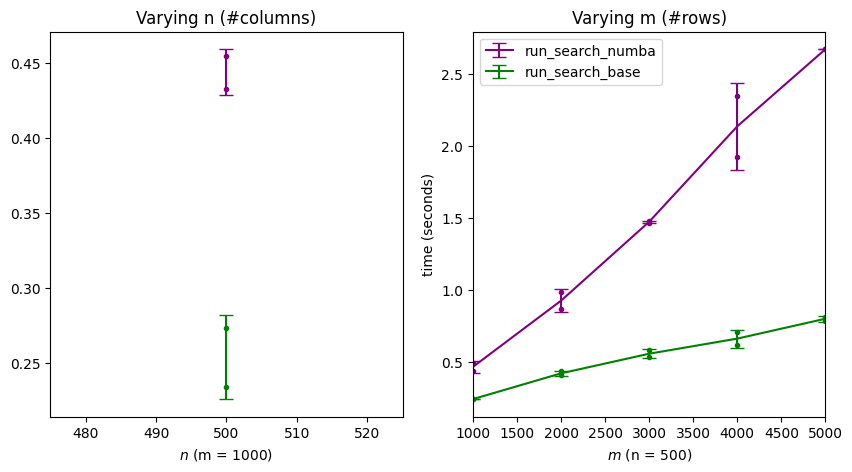

In [10]:
from statistics import mean, stdev
from matplotlib.markers import MarkerStyle
import matplotlib.pyplot as plt
from numpy import average
label_to_colors = {
  'run_search_base': 'green',
  'run_search_numba': 'purple'
}
plt.subplots(1, 2, figsize=(10, 5))

plt.ylabel('time (seconds)')
for i, benchmark in enumerate(benchmark_configs):
  plt.subplot(1, 2, i+1)
  plt.xlim(benchmark['iterator'][0], benchmark['iterator'][-1])
  plt.title(benchmark['display']['title'])
  plt.xlabel(benchmark['display']['xlabel'])
  for label, time_result in benchmark_results[benchmark['name']].items():
    for i in benchmark['iterator']:
      plt.scatter([i]*NUM_REPEATS, time_result[i], c=label_to_colors[label], marker='.')
    plt.errorbar(benchmark['iterator'], [mean(time_result[i]) for i in benchmark['iterator']], yerr=[stdev(time_result[i]) for i in benchmark['iterator']], marker='', capsize=5.0, label=label, c=label_to_colors[label])
plt.legend()

plt.show()